In [108]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [117]:
#Read the csv file
df = pd.read_csv("price_temp_total.csv")
# df['SETTLEMENTDATE'] =  pd.to_datetime(df['SETTLEMENTDATE'], format='%Y%m%d %H:%M:%S')
df = df[df['SETTLEMENTDATE']< '2021-09-30 00:00:00']
print(df.head())


   Unnamed: 0       SETTLEMENTDATE  TOTALDEMAND     RRP  Tempreture
0           1  2018-01-01 01:00:00      1242.28  103.31        17.3
1           3  2018-01-01 02:00:00      1112.46   85.24        17.0
2           5  2018-01-01 03:00:00      1083.94   80.89        16.6
3           7  2018-01-01 04:00:00      1032.95   80.10        16.3
4           9  2018-01-01 05:00:00      1034.12   80.07        16.1


In [118]:
train_dates = pd.to_datetime(df['SETTLEMENTDATE'])

#Variables for training
cols = list(df)[2:6]
#Date is not used in training. 
print(cols) 
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)
print(df_for_training.head)
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training.shape)
# print(df_for_training_scaled.shape)

['TOTALDEMAND', 'RRP', 'Tempreture']
<bound method NDFrame.head of        TOTALDEMAND     RRP  Tempreture
0          1242.28  103.31        17.3
1          1112.46   85.24        17.0
2          1083.94   80.89        16.6
3          1032.95   80.10        16.3
4          1034.12   80.07        16.1
...            ...     ...         ...
32826      1360.80   67.34        17.5
32827      1387.10   54.55        16.6
32828      1335.37   51.77        15.7
32829      1263.38   47.82        15.1
32830      1189.44   54.18        14.7

[32831 rows x 3 columns]>
(32831, 3)


In [119]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 1]) # 1 --> column of RRP
    
#In my case, trainX1 has a shape (40690 , 14, 3). 
#40690 because we are looking back 14 days (40704  - 14 = 40690). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#To predict more days in future, we need all the 3 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (32817, 14, 3).
trainY shape == (32817, 1).


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 128)           67584     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 117,057
Trainable params: 117,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2110/2110 [==============================] - 36s 16ms/step - loss: 1.0317 - val_loss: 0.2387
Epoch 2/10
2110/2110 [==============================] - 33s 16ms/step - loss

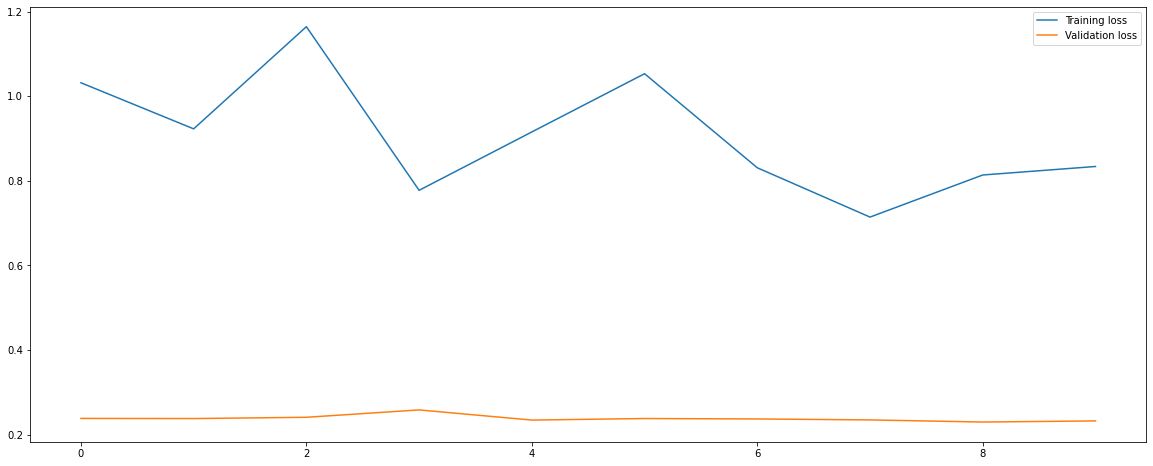

In [120]:
# define the model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=14, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [121]:
model.save('model1')

INFO:tensorflow:Assets written to: model1\assets


In [98]:
model = load_model('model1')

In [142]:
#Predicting seen data
#Remember that we can only predict one day in future as our model needs 5 variables

n_past = 16
n_days_for_prediction=100 #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[:100]) #shape = (n, n_past_from_training, n_of_columns) where n is the n_days_for_prediction
print(prediction.shape)


4/4 [==============================] - 0s 7ms/step
(100, 1)


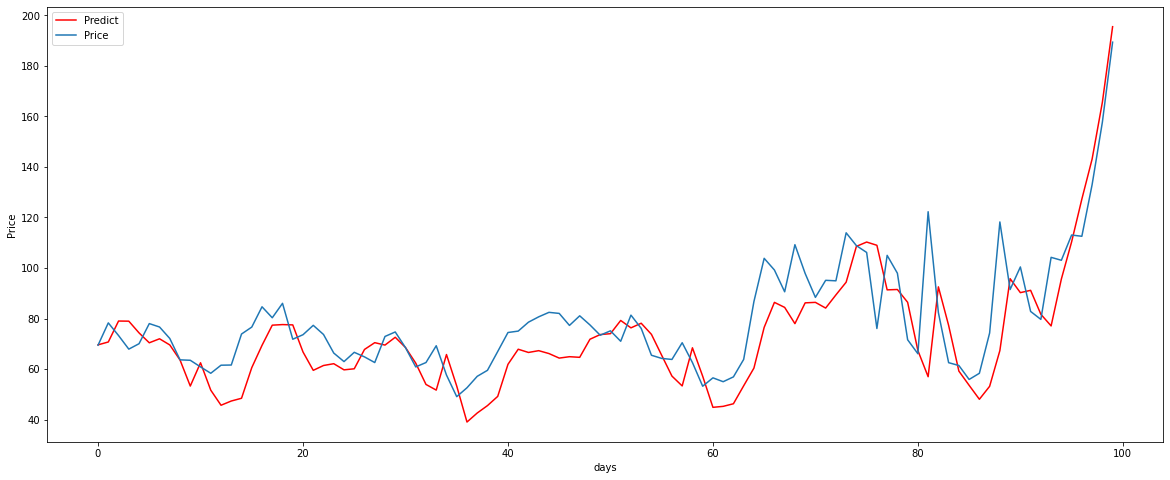

In [143]:
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times to make shape similar to original data to inverse transform.
#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_copies)[:,1] # 1 -->  RRP

prediction_copies = np.repeat(trainY[:100], df_for_training.shape[1], axis=-1)
y_inverse = scaler.inverse_transform(prediction_copies)[:,1] #  1 -->  RRP

plt.plot(y_pred,c='red',label="Predict")
plt.plot(y_inverse,label="Price")
plt.legend(loc="upper left")
plt.xlabel("days")
plt.ylabel("Price")
plt.show()


In [144]:
Error = y_pred - y_inverse
Err_2 = np.power(Error, 2)

MBE = np.mean(Error)
print(f'MBE is  {MBE}')
NMBE = MBE/ np.mean(y_inverse)
print(f'NMBE is  {NMBE}')
Err_2 = np.power(Error, 2)
print(f'R-square {sum(Err_2)}')
NRMSE = np.sqrt(np.mean(Err_2))/np.mean(y_inverse)
print(f'NRMSE is  {NRMSE}')

MBE is  -6.249883602905274
NMBE is  -0.07872252504878083
R-square 20790.453139001962
NRMSE is  0.18161807330831065


In [145]:
#Predicting Unseen data
#Remember that we can only predict one day in future as our model needs 5 variables

n_past = 16
n_days_for_prediction=100 #let us predict past 15 days

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
# print(predict_period_dates)

# testX, testY = np.array(trainX[-100:]), np.array(trainY[-100:])
#Make prediction
prediction = model.predict(trainX[-100:-50]) #shape = (n, n_past_from_training, n_of_columns) where n is the n_days_for_prediction

print(prediction.shape)


2/2 [==============================] - 0s 13ms/step
(50, 1)


In [146]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
prediction_copies = scaler.inverse_transform(prediction_copies)[:,1]
# unseen_data = df_for_training.iloc[-100:-50,0].values
# unseen_data = df_for_training.iloc[-200:-100,0].values
# plt.plot(y_pred_future,c='red')
# plt.plot(unseen_data)
# plt.show()
prediction_copies.shape
# prediction_copies

(50,)

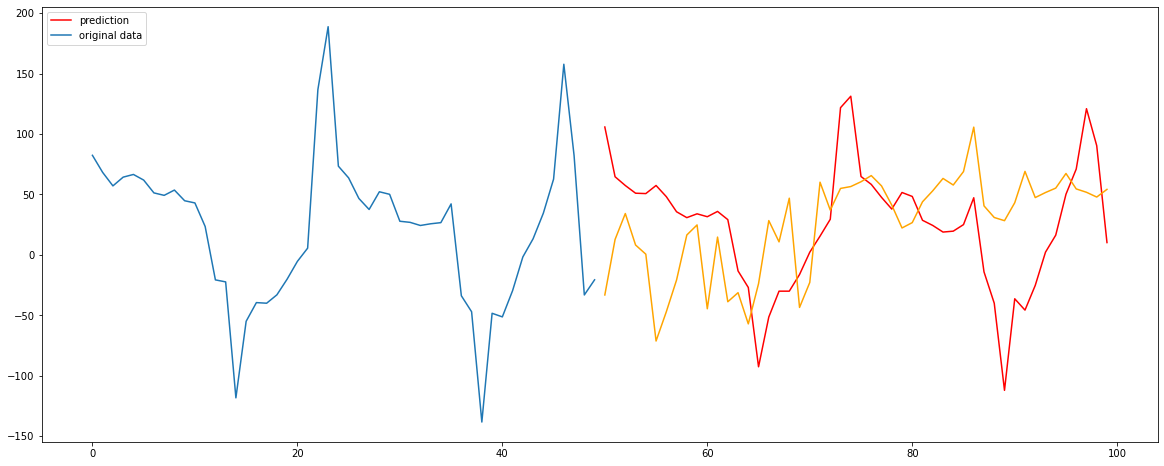

In [150]:
plt.rcParams["figure.figsize"] = (20,8)

original = df[['SETTLEMENTDATE', 'RRP']].iloc[-100:-50,]
original['date']=range(0,50)

predict = pd.DataFrame(data=prediction_copies, columns=['pred'])
predict['date']=range(50,100)

original2 = df[['SETTLEMENTDATE', 'RRP']].iloc[-50:,]
original2['date']=range(50,100)


plt.plot(predict.date, predict.pred, c='red', label='prediction')
plt.plot(original.date, original.RRP,label='original data')
plt.plot(original2.date, original2.RRP,c='orange')
plt.legend(loc="upper left")
plt.show()

In [141]:
Error = original2['RRP'].values - predict['pred'].values
Err_2 = np.power(Error, 2)

MBE = np.mean(Error)
print(f'MBE is  {MBE}')
NMBE = MBE/ np.mean(original2['RRP'].values)
print(f'NMBE is  {NMBE}')
Err_2 = np.power(Error, 2)
print(f'R-square {sum(Err_2)}')
NRMSE = np.sqrt(np.mean(Err_2))/np.mean(original2['RRP'].values)
print(f'NRMSE is  {NRMSE}')

MBE is  5.0003755836884185
NMBE is  0.2010376347831336
R-square 258759.19069495282
NRMSE is  2.640261890217022
